<h2> <strong>Часть 2 - анализ текстовых данных </strong></h2>
Провести аналитику текстовых данных.

Токенезировать и лемматизировать полученные текстовые данные полученные из 1 части задания
Токенизация - разделение слов на предложения
Лемматизация - перевод слов в начальную форму
Посчитать наиболее встречающиеся пары подлежащих и сказуемых
Посчитать самые популлярные слова (исключая стоп-слова, словарь стоп слов можно найти в nltk, либо отбросить по частям речи)
Вывести статистику (по убыванию, наиболее встречающеся пары и самые популярные слова за исключением стоп-слов)

In [8]:
import sqlite3
import natasha
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import string
from pandas import DataFrame
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Potron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<h2>Достаём данные из базы

In [25]:
connection = sqlite3.connect('articles.db')
cursor = connection.cursor()
cursor.execute("""SELECT title FROM articles LIMIT 100""")
title = cursor.fetchall()
cursor.execute("""SELECT contents FROM articles LIMIT 100""")
content = cursor.fetchall()

<h2>Подготовка

In [26]:
data = dict(zip(title, content))

from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

<h2>1. Токенезировать и лемматизировать полученные текстовые данные полученные из 1 части задания

<h3> Синтаксис

In [27]:
from ipymarkup import show_dep_ascii_markup as show_markup
articles = list(data.values())
articleForSyntax = articles[0]

doc = Doc(str(articleForSyntax))
doc.segment(segmenter)
doc.parse_syntax(syntax_parser)
doc.tag_morph(morph_tagger)

for sentence in doc.sents: # получаем предложения
  sentence.syntax.print()

┌────────────► (          punct
│           ┌► '          punct
│ ┌►┌─┌───┌─└─ Видеокарты nsubj
│ │ │ │ ┌─└►┌─ Radeon     appos
│ │ │ │ │   └► RX         flat:foreign
│ │ │ │ └────► 6000       appos
│ │ │ └──────► ,          punct
│ │ └────────► как        case
│ │     ┌────► мы         nsubj
│ │     │   ┌► уже        advmod
│ │     │ ┌►└─ сегодня    advmod
└─└─┌─┌─└─└─── говорили   
    │ │   ┌──► ,          punct
    │ │   │ ┌► постепенно advmod
    │ └►┌─└─└─ исчезают   conj
    │   │   ┌► из         case
    │   └──►└─ продажи    obl
    └────────► .          punct
        ┌────► Это      nsubj
        │   ┌► не       advmod
        │ ┌►└─ очень    advmod
┌───────└─└─── хорошо   
│       │   ┌► для      case
│       └──►└─ геймеров obl
│ ┌──────────► ,        punct
│ │ ┌──────►┌─ так      mark
│ │ │       └► как      fixed
│ │ │ ┌────►┌─ линейка  nsubj
│ │ │ │ ┌─┌─└► Radeon   appos
│ │ │ │ │ └──► RX       flat:foreign
│ │ │ │ └────► 7000     appos
│ └─└─└───┌─── включает 
│        

<h3>Токенизация

In [28]:
for sentence in doc.sents:
  for token in sentence.tokens:
    print(token)

DocToken(stop=1, text='(', id='1_1', head_id='1_12', rel='punct', pos='PUNCT')
DocToken(start=1, stop=2, text="'", id='1_2', head_id='1_3', rel='punct', pos='PUNCT')
DocToken(start=2, stop=12, text='Видеокарты', id='1_3', head_id='1_12', rel='nsubj', pos='NOUN', feats=<Inan,Nom,Masc,Plur>)
DocToken(start=13, stop=19, text='Radeon', id='1_4', head_id='1_3', rel='appos', pos='X', feats=<Yes>)
DocToken(start=20, stop=22, text='RX', id='1_5', head_id='1_4', rel='flat:foreign', pos='X', feats=<Yes>)
DocToken(start=23, stop=27, text='6000', id='1_6', head_id='1_4', rel='appos', pos='NUM')
DocToken(start=27, stop=28, text=',', id='1_7', head_id='1_3', rel='punct', pos='PUNCT')
DocToken(start=29, stop=32, text='как', id='1_8', head_id='1_3', rel='case', pos='SCONJ')
DocToken(start=33, stop=35, text='мы', id='1_9', head_id='1_12', rel='nsubj', pos='PRON', feats=<Nom,Plur,1>)
DocToken(start=36, stop=39, text='уже', id='1_10', head_id='1_11', rel='advmod', pos='ADV', feats=<Pos>)
DocToken(start=4

<h3>Лемматизация

In [29]:
# Заменяем слова на их леммы (начальные формы слова)
for sentence in doc.sents:
  for token in sentence.tokens:
    token.lemmatize(morph_vocab)
  lemmas = {_.text: _.lemma for _ in sentence.tokens}
  print(lemmas.items())

dict_items([('(', '('), ("'", "'"), ('Видеокарты', 'видеокарта'), ('Radeon', 'radeon'), ('RX', 'rx'), ('6000', '6000'), (',', ','), ('как', 'как'), ('мы', 'мы'), ('уже', 'уже'), ('сегодня', 'сегодня'), ('говорили', 'говорить'), ('постепенно', 'постепенно'), ('исчезают', 'исчезать'), ('из', 'из'), ('продажи', 'продажа'), ('.', '.')])
dict_items([('Это', 'это'), ('не', 'не'), ('очень', 'очень'), ('хорошо', 'хороший'), ('для', 'для'), ('геймеров', 'геймер'), (',', ','), ('так', 'так'), ('как', 'как'), ('линейка', 'линейка'), ('Radeon', 'radeon'), ('RX', 'rx'), ('7000', '7000'), ('включает', 'включать'), ('меньше', 'меньше'), ('моделей', 'модель'), ('.', '.')])
dict_items([('Однако', 'однако'), ('хорошая', 'хороший'), ('новость', 'новость'), ('в', 'в'), ('том', 'тот'), (',', ','), ('что', 'что'), ('видеокарты', 'видеокарта'), ('RX', 'rx'), ('7000', '7000'), ('активно', 'активно'), ('дешевеют', 'дешеветь'), ('.', '.')])
dict_items([('Буквально', 'буквально'), ('недавно', 'недавно'), ('AMD',

<h2>2. Посчитать наиболее встречающиеся пары подлежащих и сказуемых

<h3> Пары для одной статьи

In [30]:
pairs_of_nsubj_and_root = []
for sentence in doc.sents:
    nsubj = root = ''
    for token in sentence.tokens:
        token.lemmatize(morph_vocab)
        if token.rel in {"nsubj", "root"}:
            if token.rel == "nsubj":
                nsubj = token.lemma
            elif token.rel == "root":
                root = token.lemma
            if nsubj and root:
                pairs_of_nsubj_and_root.append((nsubj, root))

print(pairs_of_nsubj_and_root)

[('мы', 'говорить'), ('это', 'хороший'), ('линейка', 'хороший'), ('линейка', 'включать'), ('новость', 'тот'), ('видеокарта', 'тот'), ('amd', 'снижать'), ('цена', 'снижать'), ('цена', 'упасть'), ('продавец', 'предлагать'), ('это', 'предлагать'), ('ситуация', 'быть'), ('ситуация', 'схожий'), ('карта', 'схожий'), ('это', 'схожий'), ('rx', 'схожий'), ('адаптер', 'дорогой'), ('адаптер', 'производительнее'), ('последний', 'производительнее'), ('последний', 'стоить')]


<h3> Пары для всех статей

In [31]:
all_pairs_of_nsubj_and_root = []
for article in articles:
  doc = Doc(str(article))
  doc.segment(segmenter)
  doc.parse_syntax(syntax_parser)
  doc.tag_morph(morph_tagger)
  for sentence in doc.sents:
    nsubj = root = ''
    for token in sentence.tokens:
      token.lemmatize(morph_vocab)
      if token.rel == "nsubj":
        nsubj = token.lemma
      if token.rel == 'root':
        root = token.lemma
      if nsubj and root:
        all_pairs_of_nsubj_and_root.append((nsubj, root))

print(all_pairs_of_nsubj_and_root)

[('мы', 'говорить'), ('мы', 'говорить'), ('мы', 'говорить'), ('мы', 'говорить'), ('мы', 'говорить'), ('мы', 'говорить'), ('мы', 'говорить'), ('это', 'хороший'), ('это', 'хороший'), ('это', 'хороший'), ('это', 'хороший'), ('это', 'хороший'), ('это', 'хороший'), ('линейка', 'хороший'), ('линейка', 'хороший'), ('линейка', 'хороший'), ('линейка', 'хороший'), ('линейка', 'включать'), ('линейка', 'включать'), ('линейка', 'включать'), ('линейка', 'включать'), ('новость', 'тот'), ('новость', 'тот'), ('новость', 'тот'), ('видеокарта', 'тот'), ('видеокарта', 'тот'), ('видеокарта', 'тот'), ('видеокарта', 'тот'), ('видеокарта', 'тот'), ('видеокарта', 'тот'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd', 'снижать'), ('amd

<h3> Наиболее встречающиеся фразы

In [32]:
all_pairs_counter = Counter(all_pairs_of_nsubj_and_root)
all_pairs_counter.most_common(20) # используется метод объекта Counter

[(('который', 'представить'), 113),
 (('мы', 'отмечать'), 68),
 (('рост', 'связать'), 56),
 (('что', 'выявить'), 54),
 (('смартфон', 'опираться'), 53),
 (('это', 'больше'), 51),
 (('машина', 'продаваться'), 51),
 (('они', 'иметь'), 49),
 (('это', 'заявлять'), 49),
 (('версия', 'оснащать'), 48),
 (('команды-участник', 'смочь'), 47),
 (('достижение', 'являться'), 46),
 (('менеджер', 'подписать'), 46),
 (('он', 'мочь'), 45),
 (('речь', 'идти'), 43),
 (('команда', 'объявить'), 43),
 (('аппарат', 'готовый'), 43),
 (('они', 'провести'), 41),
 (('россиянин', 'потратить'), 41),
 (('этап', 'отмечать'), 40)]

<h2> 3. Самые популярные слова (без стоп-слов, цифр и знаков пунктуации)

In [33]:
popular_words = []
delete_punctuation = set(string.punctuation + '«»—' + string.digits + 'n')
stop_words = set(stopwords.words('russian'))
for article in articles:
  doc = Doc(str(article))
  doc.segment(segmenter)
  doc.parse_syntax(syntax_parser)
  doc.tag_morph(morph_tagger)
  for sentence in doc.sents:
    for token in sentence.tokens:
      token.lemmatize(morph_vocab)
      if token.lemma not in delete_punctuation and token.lemma not in stop_words:
        popular_words.append(token.lemma)

filtered_count = Counter(popular_words)
filtered_count.most_common(20)

[('xa', 133),
 ('год', 131),
 ('новый', 104),
 ('это', 95),
 ('который', 84),
 ('компания', 58),
 ('автомобиль', 53),
 ('рубль', 53),
 ('свой', 51),
 ('весь', 50),
 ('также', 48),
 ('цена', 47),
 ('машина', 44),
 ('млн', 44),
 ('первый', 42),
 ('мочь', 36),
 ('доллар', 35),
 ('рынок', 34),
 ('получить', 34),
 ('заявить', 32)]

Топ 5 популярных слов: ха, год, новый, это, который 

<h2>4. Статистика

<h3>По встречающимся парам "подлежащее + сказуемое" в статьях

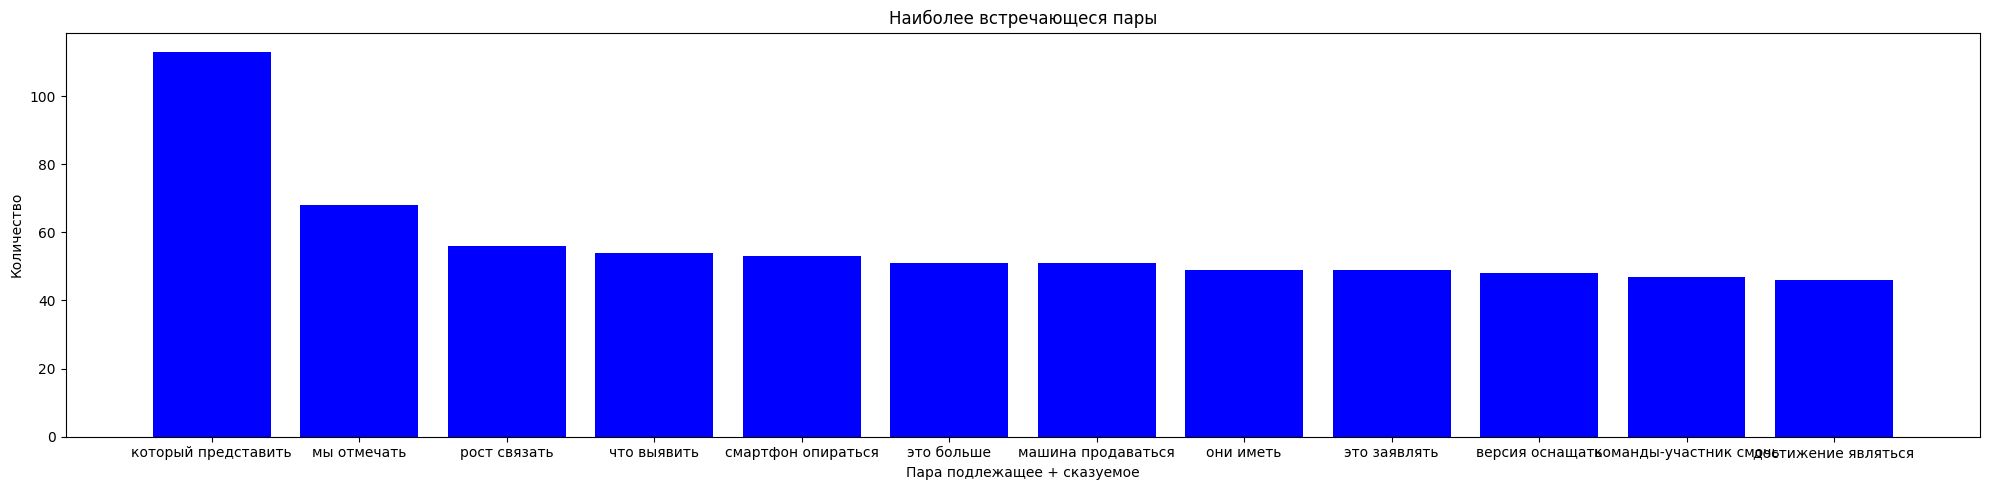

In [34]:
pairs = [pair[0][0] + ' ' + pair[0][1] for pair in all_pairs_counter.most_common(12)]
counter = [pair[1] for pair in all_pairs_counter.most_common(12)]

plt.figure(figsize=(20, 5))
plt.bar(pairs, counter, color = 'blue')
plt.title("Наиболее встречающеся пары")
plt.ylabel("Количество")
plt.xlabel("Пара подлежащее + сказуемое")
plt.tight_layout()
plt.show()

<h3>По словам

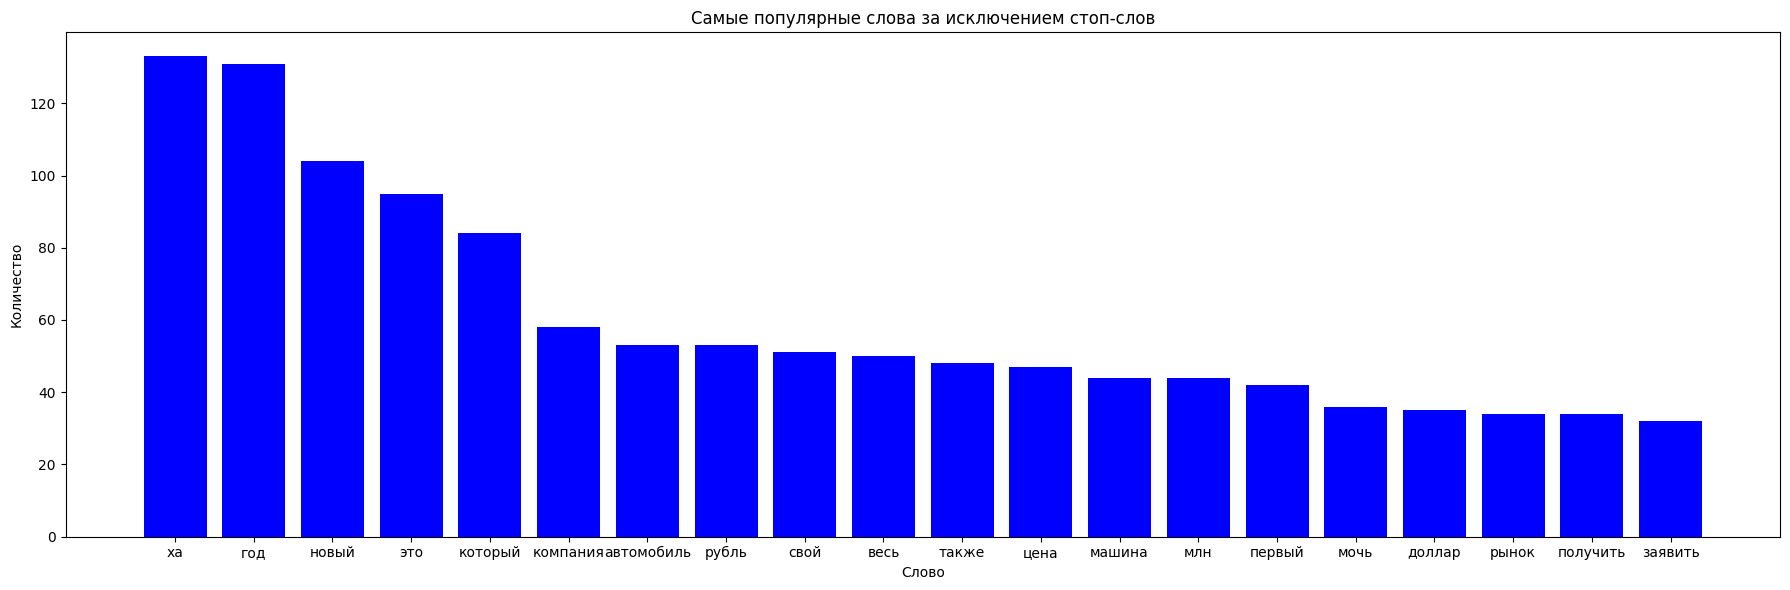

In [35]:
words = [pair[0] for pair in filtered_count.most_common(20)]
counter = [pair[1] for pair in filtered_count.most_common(20)]

plt.figure(figsize=(18, 6))
plt.bar(words, counter, color = 'blue')
plt.title("Самые популярные слова за исключением стоп-слов")
plt.ylabel("Количество")
plt.xlabel("Слово")
plt.tight_layout()
plt.show()